In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

Using TensorFlow backend.


In [160]:


# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    leaf_files = np.array(data['filenames'])
    leaf_targets = np_utils.to_categorical(np.array(data['target']), 100)
    return leaf_files, leaf_targets

# load train, test, and validation datasets
# https://archive.ics.uci.edu/ml/datasets/One-hundred+plant+species+leaves+data+set
train_files, train_targets = load_dataset('data')
leaf_names = [item[5:-1] for item in sorted(glob("data/*/"))]


print('There are %d total leaf categories.' % len(leaf_names))


There are 100 total leaf categories.


In [165]:
train_files[0]

'data/67.Quercus_Ilex/Quercus_Ilex_02.ab.jpg'

In [159]:
'''
import os
ldir = sorted(os.listdir('data/'))
for i, dir in enumerate(ldir):
    if i < 10:
        i = '0' + str(i)
    #os.rename('data/'+dir, )
    os.rename('data/'+dir, 'data/'+ str(i) + '.' + dir)
'''

In [168]:
(x_train, x_valid, x_test) = train_files[:1000], train_files[1000:1300], train_files[1300:]
(y_train, y_valid, y_test) = train_targets[:1000], train_targets[1000:1300], train_targets[1300:]

In [162]:
x_train.shape

(1000,)

In [163]:
x_valid.shape

(300,)

In [164]:
x_test.shape

(300,)

In [169]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [170]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(x_train).astype('float32')/255
valid_tensors = paths_to_tensor(x_valid).astype('float32')/255
test_tensors = paths_to_tensor(x_test).astype('float32')/255

100%|██████████| 300/300 [00:00<00:00, 570.90it/s]


In [171]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_tensors)

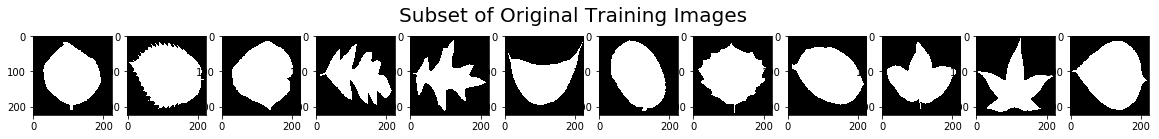

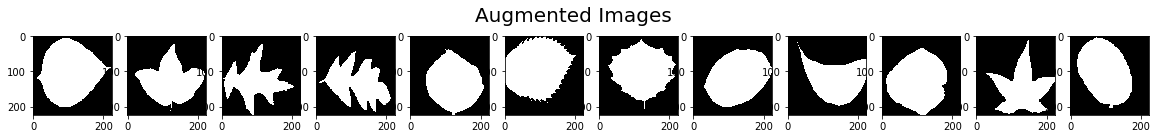

In [172]:
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = train_tensors[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

In [294]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(100, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 128)       32896     
__________

In [295]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [296]:
batch_size = 50
epochs = 100

# train the model
checkpointer = ModelCheckpoint(filepath='saved_models/aug_model.weights.best-2.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(train_tensors, y_train, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=(valid_tensors, y_valid),
                    validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/100
Epoch 00000: val_loss improved from inf to 4.57193, saving model to saved_models/aug_model.weights.best-2.hdf5
8s - loss: 4.9269 - acc: 0.0180 - val_loss: 4.5719 - val_acc: 0.0567
Epoch 2/100
Epoch 00001: val_loss improved from 4.57193 to 4.33811, saving model to saved_models/aug_model.weights.best-2.hdf5
8s - loss: 4.5254 - acc: 0.0390 - val_loss: 4.3381 - val_acc: 0.0800
Epoch 3/100
Epoch 00002: val_loss improved from 4.33811 to 3.87131, saving model to saved_models/aug_model.weights.best-2.hdf5
8s - loss: 4.2506 - acc: 0.0800 - val_loss: 3.8713 - val_acc: 0.1100
Epoch 4/100
Epoch 00003: val_loss improved from 3.87131 to 3.65571, saving model to saved_models/aug_model.weights.best-2.hdf5
7s - loss: 3.9357 - acc: 0.1330 - val_loss: 3.6557 - val_acc: 0.1733
Epoch 5/100
Epoch 00004: val_loss improved from 3.65571 to 3.22656, saving model to saved_models/aug_model.weights.best-2.hdf5
8s - loss: 3.6621 - acc: 0.1650 - val_loss: 3.2266 - val_acc: 0.2200
Epoch 6/100
Epoch 00005:

Epoch 00048: val_loss did not improve
7s - loss: 0.7053 - acc: 0.7750 - val_loss: 0.7448 - val_acc: 0.7700
Epoch 50/100
Epoch 00049: val_loss did not improve
7s - loss: 0.7075 - acc: 0.7630 - val_loss: 0.7911 - val_acc: 0.7433
Epoch 51/100
Epoch 00050: val_loss did not improve
7s - loss: 0.6994 - acc: 0.7660 - val_loss: 0.7581 - val_acc: 0.7567
Epoch 52/100
Epoch 00051: val_loss did not improve
7s - loss: 0.7210 - acc: 0.7790 - val_loss: 0.7766 - val_acc: 0.7500
Epoch 53/100
Epoch 00052: val_loss did not improve
7s - loss: 0.6938 - acc: 0.7760 - val_loss: 0.7591 - val_acc: 0.7567
Epoch 54/100
Epoch 00053: val_loss did not improve
7s - loss: 0.7166 - acc: 0.7560 - val_loss: 0.7534 - val_acc: 0.7833
Epoch 55/100
Epoch 00054: val_loss did not improve
7s - loss: 0.6999 - acc: 0.7730 - val_loss: 0.8217 - val_acc: 0.7300
Epoch 56/100
Epoch 00055: val_loss did not improve
7s - loss: 0.6449 - acc: 0.7910 - val_loss: 0.7699 - val_acc: 0.7433
Epoch 57/100
Epoch 00056: val_loss improved from 0.73

In [297]:
#model.load_weights('saved_models/weights.best.from_scratch.hdf5')
model.load_weights('saved_models/aug_model.weights.best-2.hdf5')

In [298]:
# get index of predicted dog breed for each image in test set
leaf_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(leaf_predictions)==np.argmax(y_test, axis=1))/len(leaf_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 86.3333%


In [299]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    #return np.expand_dims(x, axis=0)
    return x

In [300]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

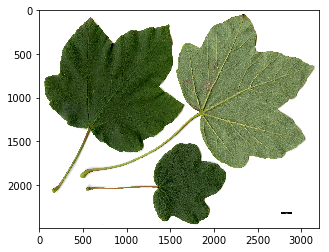

In [316]:
test_img_path = 'real-world-images/lleaf-4.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [317]:
test_img_tensor = path_to_tensor(test_img_path)
leaf_prediction = [np.argmax(model.predict(np.expand_dims(test_img_tensor, axis=0)))]

In [318]:
leaf_prediction

[22]

In [285]:
for i, l in enumerate(leaf_names):
    print('{}, {}'.format(i, l))
    

0, 00.Acer_Campestre
1, 01.Acer_Capillipes
2, 02.Acer_Circinatum
3, 03.Acer_Mono
4, 04.Acer_Opalus
5, 05.Acer_Palmatum
6, 06.Acer_Pictum
7, 07.Acer_Platanoids
8, 08.Acer_Rubrum
9, 09.Acer_Rufinerve
10, 10.Acer_Saccharinum
11, 11.Alnus_Cordata
12, 12.Alnus_Maximowiczii
13, 13.Alnus_Rubra
14, 14.Alnus_Sieboldiana
15, 15.Alnus_Viridis
16, 16.Arundinaria_Simonii
17, 17.Betula_Austrosinensis
18, 18.Betula_Pendula
19, 19.Callicarpa_Bodinieri
20, 20.Castanea_Sativa
21, 21.Celtis_Koraiensis
22, 22.Cercis_Siliquastrum
23, 23.Cornus_Chinensis
24, 24.Cornus_Controversa
25, 25.Cornus_Macrophylla
26, 26.Cotinus_Coggygria
27, 27.Crataegus_Monogyna
28, 28.Cytisus_Battandieri
29, 29.Eucalyptus_Glaucescens
30, 30.Eucalyptus_Neglecta
31, 31.Eucalyptus_Urnigera
32, 32.Fagus_Sylvatica
33, 33.Ginkgo_Biloba
34, 34.Ilex_Aquifolium
35, 35.Ilex_Cornuta
36, 36.Liquidambar_Styraciflua
37, 37.Liriodendron_Tulipifera
38, 38.Lithocarpus_Cleistocarpus
39, 39.Lithocarpus_Edulis
40, 40.Magnolia_Heptapeta
41, 41.Magnol